# Somatic variant calling from Minimap2 vs BWA
BWA and minimap2 resulted in slightly different variant calling validation results, running on the ICGC MB dataset (100x tumor vs 100x normal). Trying to analyse the origin of that discrepancy.

In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import median, mean
from pprint import pprint
import sys

from ipywidgets import interact, interactive, fixed, interact_manual, widgets
from IPython.display import display

benchmark_d = {
    'mb': {
        'path': 'mb/eval/batch1-{c}-annotated-{aln}_bcftools_isec',
        'callers': ['ensemble', 'strelka2', 'vardict', 'mutect2'],
        'df': None,
    },
    'giab': {
        'path': 'giab/eval/UtahMormon-1-{aln}-{c}-annotated_bcftools_isec',
        'callers': ['ensemble', 'strelka2', 'vardict', 'gatk-haplotype'],
        'df': None,
    },
    'colo': {
        'path': 'colo/eval/COLO_TGEN_{aln}-{c}-annotated_bcftools_isec',
        'callers': ['ensemble', 'strelka2', 'vardict', 'mutect2'],
        'df': None,
    }
}
for n, b in benchmark_d.items(): 
    b['name'] = n

benchmarks_names = ['mb', 'colo', 'giab']
benchmarks = [benchmark_d[n] for n in benchmarks_names]


Parsing VCF for Strelka2, VarDict, and Mutect2 paired somatic calls. Earlier we evaluated calls against the truth set, so here we have 3 sets of VCFs for each caller: `0000.vcf` (false positives), `0001.vcf` (false negatives), `0002.vcf` (true positives).

In [234]:
from cyvcf2 import VCF
from collections import defaultdict
from ngs_utils.vcf_utils import get_tumor_sample_id
from os.path import join
from collections import Counter

def int_to_chrom(val):
    if val == 23: return 'X'
    if val == 24: return 'Y'
    if val == 25: return 'MT'
    if val == 0: return None
    return str(val)
    
def chrom_to_int(chrom):
    if chrom == 'X': return 23
    if chrom == 'Y': return 24
    if chrom == 'MT': return 25
    try:
        return int(chrom)
    except:
        return 0

with open('GRCh37.fa.fai') as f:
    chrom_lens = [(l.split('\t')[0], int(l.split('\t')[1])) for l in f if l.strip()]
    chrom_lens = [(c, l) for c, l in chrom_lens if not c.startswith('GL')]
chrom_positions = [(chrom, sum(l for c, l in chrom_lens if chrom_to_int(c) < chrom_to_int(chrom))) 
                        for chrom, _ in chrom_lens] \
                   + [(None, sum(l for c, l in chrom_lens))]
    
main_sample_index = 0  # get_tumor_sample_id(mm2_vcf)

def reject_variant(rec):
    reject = False
    return reject
    
def rec_to_fields(rec, aln_name, caller):
    fields = dict()
    for tag in ['AF', 'DP', 'MQ']:
        for ph in ['TUMOR', 'NORMAL']:
            v = rec.INFO.get(f'{ph}_{tag}')
            if v is not None:
                fields[f'{aln_name}_{ph}_{tag}'] = v

    fields[f'{aln_name}_QUAL'] = rec.QUAL

    if caller == 'vardict':
        fields[f'{aln_name}_NM'] = rec.format('NM')[main_sample_index][0]

    ann = rec.INFO.get('ANN')
    if isinstance(ann, str):  # skip decomposed fields with lost ANN
        fields['gene'] = ann.split('|')[3]

    if caller == 'strelka2':
        fields[f'{aln_name}_SomaticEVS'] = rec.INFO.get('SomaticEVS')
        fields[f'{aln_name}_ReadPosRankSum'] = rec.INFO.get('ReadPosRankSum')
        
    return fields
    
def load_vcfs(bn, types=None):
    print('Loading for benchmark ' + bn)
    print('--------------------------')
    b = benchmark_d[bn]

    vcfs = defaultdict(dict)
    for c in b['callers']:
        for aln in ['bwa', 'mm2']:
            vcfs[c][aln] = dict(
                fp=join(b['path'].format(aln=aln, c=c), '0000.vcf'),
                fn=join(b['path'].format(aln=aln, c=c), '0001.vcf'),
                tp=join(b['path'].format(aln=aln, c=c), '0002.vcf'),    
            )
            if types:
                for typ in ['fp', 'fn', 'tp']:
                    if typ not in types:
                        del vcfs[c][aln][typ]
            
    rows = []
    for caller in b['callers']:
        print(f'Parsing VCFs for {caller}')
        recs_by_loc = defaultdict(lambda: [(None, 'tn'), (None, 'tn')])
        for typ, vcf in vcfs[caller]['bwa'].items():
            print(f'  reading {vcf}')
            for rec in VCF(vcf):    
                k = (rec.CHROM, rec.POS, rec.REF, rec.ALT[0])
                recs_by_loc[k][0] = (rec, typ)            
        for typ, vcf in vcfs[caller]['mm2'].items():
            print(f'  reading {vcf}')
            for rec in VCF(vcf):
                k = (rec.CHROM, rec.POS, rec.REF, rec.ALT[0])
                recs_by_loc[k][1] = (rec, typ)

        print(f'Analysing data for {caller}, building dataframe')
        total = 0
        passed = 0
        for (chrom, pos, ref, alt), [(bwa, bwa_t), (mm2, mm2_t)] in sorted(recs_by_loc.items(), key=lambda a: a[0]):    
            assert bwa_t and mm2_t
            total += 1

            x = next((p for c, p in chrom_positions if str(c) == str(chrom)), None)
            if x is None:
                continue
            x += pos

            fields = dict(gene='')

            for aln_name, rec, aln_type in (['bwa', bwa, bwa_t], ['mm2', mm2, mm2_t]):
                if aln_type in ('fp', 'tp'):
                    fields.update(rec_to_fields(rec, aln_name, caller))
                    
            if bwa is not None and mm2 is not None:
                assert bwa.is_snp == mm2.is_snp, (bwa, bwa_t, mm2, mm2_t)

            positive_rec = bwa if bwa is not None else mm2
            if reject_variant(positive_rec):
                continue
            assert positive_rec is not None, (str(bwa).replace('\t', '  '), str(mm2))
            passed += 1

            tricky_anno = positive_rec.INFO.get('TRICKY', '').split(',')
            tricky_anno = tuple([a for a in tricky_anno if a and a not in 
                 ['heng_um75-hs37d5', 'self_chain', 'bad_promoter', 'gc20to25', 'gc25to30', 'gc65to70']])

            row = {
                'caller': caller,
                'pos': pos,
                'label': f'{chrom}:{pos}-{ref}>{alt}', 
                'called_with_bwa': bwa_t in ('tp', 'fp'),
                'called_with_mm2': mm2_t in ('tp', 'fp'),
                'chrom': chrom,
                'x': x,
                'is_snp': positive_rec.is_snp,
                'tricky_anno': tricky_anno,
                'bwa_t': bwa_t,
                'mm2_t': mm2_t,
            }
            row.update(fields)
            rows.append(row)

        print(f'Done parsing {total} {caller} variants, saved {passed}')
        print()
        
    df = pd.DataFrame(rows).set_index('label')
    if types is None:
        b['df'] = df
    return df
pass

In [228]:
load_vcfs('mb')

Loading for benchmark mb
--------------------------
Parsing VCFs for ensemble
  reading mb/eval/batch1-ensemble-annotated-bwa_bcftools_isec/0000.vcf
  reading mb/eval/batch1-ensemble-annotated-bwa_bcftools_isec/0001.vcf
  reading mb/eval/batch1-ensemble-annotated-bwa_bcftools_isec/0002.vcf
  reading mb/eval/batch1-ensemble-annotated-mm2_bcftools_isec/0000.vcf
  reading mb/eval/batch1-ensemble-annotated-mm2_bcftools_isec/0001.vcf
  reading mb/eval/batch1-ensemble-annotated-mm2_bcftools_isec/0002.vcf
Analysing data for ensemble, building dataframe
Done parsing 2383 ensemble variants, saved 2383

Parsing VCFs for strelka2
  reading mb/eval/batch1-strelka2-annotated-bwa_bcftools_isec/0000.vcf
  reading mb/eval/batch1-strelka2-annotated-bwa_bcftools_isec/0001.vcf
  reading mb/eval/batch1-strelka2-annotated-bwa_bcftools_isec/0002.vcf
  reading mb/eval/batch1-strelka2-annotated-mm2_bcftools_isec/0000.vcf
  reading mb/eval/batch1-strelka2-annotated-mm2_bcftools_isec/0001.vcf
  reading mb/eval/

,bwa_NM,bwa_NORMAL_AF,bwa_NORMAL_DP,bwa_NORMAL_MQ,bwa_QUAL,bwa_ReadPosRankSum,bwa_SomaticEVS,bwa_TUMOR_AF,bwa_TUMOR_DP,bwa_TUMOR_MQ,...,mm2_QUAL,mm2_ReadPosRankSum,mm2_SomaticEVS,mm2_TUMOR_AF,mm2_TUMOR_DP,mm2_TUMOR_MQ,mm2_t,pos,tricky_anno,x
label,,,,,,,,,,,,,,,,,,,,,
1:603354-G>T,NaN,0.000000,32.0,55.200001,83.0,NaN,NaN,0.227300,22.0,22.400000,...,NaN,NaN,NaN,NaN,NaN,NaN,tn,603354,"(gc15, gc15to20, gc70to75, gc75to80, low_compl...",603354
1:2171787-G>A,NaN,0.000000,104.0,60.000000,163.0,NaN,NaN,0.415700,89.0,60.000000,...,163.0,NaN,NaN,0.415700,89.0,59.900002,tp,2171787,(),2171787
1:7199290-ATATATATT>A,NaN,0.000000,7.0,60.000000,78.0,NaN,NaN,0.333300,12.0,60.000000,...,78.0,NaN,NaN,0.333300,12.0,60.000000,fp,7199290,"(gc15, low_complexity_51to200bp)",7199290
1:9414323-G>A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fn,9414323,(),9414323
1:13201262-GA>G,NaN,0.024200,124.0,33.700001,194.0,NaN,NaN,0.388300,103.0,34.099998,...,190.0,NaN,NaN,0.366300,101.0,35.500000,fp,13201262,"(gc15, gc15to20, gc70to75, gc75to80, gc80to85,...",13201262
1:13852321-C>T,NaN,0.000000,77.0,NaN,0.0,NaN,NaN,0.285714,63.0,55.639999,...,0.0,NaN,NaN,0.295082,61.0,57.410000,tp,13852321,(),13852321
1:14908535-AT>A,NaN,0.011800,85.0,60.000000,200.0,NaN,NaN,0.542200,83.0,60.000000,...,199.0,NaN,NaN,0.536600,82.0,60.000000,tp,14908535,(),14908535
1:14995104-C>T,NaN,0.000000,98.0,60.000000,204.0,NaN,NaN,0.633300,90.0,60.000000,...,205.0,NaN,NaN,0.625000,88.0,59.900002,tp,14995104,(),14995104
1:20818544-G>A,NaN,0.000000,92.0,60.000000,204.0,NaN,NaN,0.666700,99.0,60.000000,...,204.0,NaN,NaN,0.673500,98.0,59.799999,tp,20818544,(),20818544


In [233]:
load_vcfs('colo')

Loading for benchmark colo
--------------------------
Parsing VCFs for ensemble
  reading colo/eval/COLO_TGEN_bwa-ensemble-annotated_bcftools_isec/0000.vcf
  reading colo/eval/COLO_TGEN_bwa-ensemble-annotated_bcftools_isec/0001.vcf
  reading colo/eval/COLO_TGEN_bwa-ensemble-annotated_bcftools_isec/0002.vcf
  reading colo/eval/COLO_TGEN_mm2-ensemble-annotated_bcftools_isec/0000.vcf
  reading colo/eval/COLO_TGEN_mm2-ensemble-annotated_bcftools_isec/0001.vcf
  reading colo/eval/COLO_TGEN_mm2-ensemble-annotated_bcftools_isec/0002.vcf
Analysing data for ensemble, building dataframe
Done parsing 45221 ensemble variants, saved 45221

Parsing VCFs for strelka2
  reading colo/eval/COLO_TGEN_bwa-strelka2-annotated_bcftools_isec/0000.vcf
  reading colo/eval/COLO_TGEN_bwa-strelka2-annotated_bcftools_isec/0001.vcf
  reading colo/eval/COLO_TGEN_bwa-strelka2-annotated_bcftools_isec/0002.vcf
  reading colo/eval/COLO_TGEN_mm2-strelka2-annotated_bcftools_isec/0000.vcf
  reading colo/eval/COLO_TGEN_mm2-s

,bwa_NM,bwa_NORMAL_AF,bwa_NORMAL_DP,bwa_NORMAL_MQ,bwa_QUAL,bwa_ReadPosRankSum,bwa_SomaticEVS,bwa_TUMOR_AF,bwa_TUMOR_DP,bwa_TUMOR_MQ,...,mm2_QUAL,mm2_ReadPosRankSum,mm2_SomaticEVS,mm2_TUMOR_AF,mm2_TUMOR_DP,mm2_TUMOR_MQ,mm2_t,pos,tricky_anno,x
label,,,,,,,,,,,,,,,,,,,,,
1:39487-A>AC,NaN,0.000000,18.0,23.799999,55.0,NaN,NaN,0.1667,18.0,23.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,tn,39487,"(gc15, gc15to20, gc70to75, gc75to80, gc80to85,...",39487
1:66008-C>G,NaN,0.000000,29.0,28.000000,98.0,NaN,NaN,0.3158,19.0,27.700001,...,75.0,NaN,NaN,0.222200,18.0,33.799999,fp,66008,"(gc15, gc15to20, gc70to75, gc75to80, gc80to85,...",66008
1:568201-T>C,NaN,0.012500,80.0,NaN,0.0,NaN,NaN,1.0000,2.0,49.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,tn,568201,"(gc15, gc15to20, gc70to75, gc75to80, low_compl...",568201
1:696644-G>A,NaN,0.000000,62.0,22.000000,184.0,NaN,NaN,1.0000,35.0,22.000000,...,184.0,NaN,NaN,1.000000,35.0,42.299999,tp,696644,"(gc15, gc15to20, gc70to75, gc75to80, low_compl...",696644
1:737643-G>A,NaN,0.013500,74.0,21.000000,103.0,NaN,NaN,0.1600,50.0,32.599998,...,NaN,NaN,NaN,NaN,NaN,NaN,tn,737643,"(gc15, gc15to20, gc70to75, gc75to80, low_compl...",737643
1:769599-A>C,NaN,0.000000,78.0,51.000000,115.0,NaN,NaN,0.1333,60.0,36.799999,...,NaN,NaN,NaN,NaN,NaN,NaN,tn,769599,"(gc15, gc15to20, gc70to75, gc75to80, low_compl...",769599
1:774409-A>G,NaN,0.019800,101.0,40.000000,127.0,NaN,NaN,0.1500,80.0,35.000000,...,122.0,NaN,NaN,0.144700,76.0,39.500000,fp,774409,"(gc15, gc15to20, gc70to75, gc75to80, low_compl...",774409
1:798745-G>C,NaN,0.000000,93.0,53.700001,104.0,NaN,NaN,0.1194,67.0,30.299999,...,NaN,NaN,NaN,NaN,NaN,NaN,tn,798745,"(gc15, gc15to20, gc70to75, gc75to80, low_compl...",798745
1:798757-C>A,NaN,0.000000,99.0,52.900002,108.0,NaN,NaN,0.1408,71.0,32.200001,...,108.0,NaN,NaN,0.138900,72.0,34.099998,fp,798757,"(gc15, gc15to20, gc70to75, gc75to80, low_compl...",798757


In [216]:
load_vcfs('giab')

Loading for benchmark giab
--------------------------
Parsing VCFs for ensemble
  reading giab/eval/UtahMormon-1-bwa-ensemble-annotated_bcftools_isec/0001.vcf
  reading giab/eval/UtahMormon-1-mm2-ensemble-annotated_bcftools_isec/0001.vcf
Analysing data for ensemble, building dataframe
Done parsing 14867 ensemble variants, saved 14867

Parsing VCFs for strelka2
  reading giab/eval/UtahMormon-1-bwa-strelka2-annotated_bcftools_isec/0001.vcf
  reading giab/eval/UtahMormon-1-mm2-strelka2-annotated_bcftools_isec/0001.vcf
Analysing data for strelka2, building dataframe
Done parsing 21169 strelka2 variants, saved 21169

Parsing VCFs for vardict
  reading giab/eval/UtahMormon-1-bwa-vardict-annotated_bcftools_isec/0001.vcf
  reading giab/eval/UtahMormon-1-mm2-vardict-annotated_bcftools_isec/0001.vcf
Analysing data for vardict, building dataframe
Done parsing 58246 vardict variants, saved 58246

Parsing VCFs for gatk-haplotype
  reading giab/eval/UtahMormon-1-bwa-gatk-haplotype-annotated_bcftools

In [ ]:
#print(df[['caller', 'is_snp', 'bwa_t', 'mm2_t', 'category', 'chrom']])

**Counting statistics on per-chromosome basis: unique to BWA vs. unqiue to minimap2 vs. common calls. Drawing summary Venn diagrams for each caller.**

Loading for benchmark mb
--------------------------
Parsing VCFs for ensemble
  reading mb/eval/batch1-ensemble-annotated-bwa_bcftools_isec/0001.vcf
  reading mb/eval/batch1-ensemble-annotated-mm2_bcftools_isec/0001.vcf
Analysing data for ensemble, building dataframe
Done parsing 199 ensemble variants, saved 199

Parsing VCFs for strelka2
  reading mb/eval/batch1-strelka2-annotated-bwa_bcftools_isec/0001.vcf
  reading mb/eval/batch1-strelka2-annotated-mm2_bcftools_isec/0001.vcf
Analysing data for strelka2, building dataframe
Done parsing 201 strelka2 variants, saved 201

Parsing VCFs for vardict
  reading mb/eval/batch1-vardict-annotated-bwa_bcftools_isec/0001.vcf
  reading mb/eval/batch1-vardict-annotated-mm2_bcftools_isec/0001.vcf
Analysing data for vardict, building dataframe
Done parsing 332 vardict variants, saved 332

Parsing VCFs for mutect2
  reading mb/eval/batch1-mutect2-annotated-bwa_bcftools_isec/0001.vcf
  reading mb/eval/batch1-mutect2-annotated-mm2_bcftools_isec/0001.vcf

/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/matplotlib_venn/_venn2.py:50: UserWarning:

Both circles have zero area

/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:47: UserWarning:

All circles have zero area



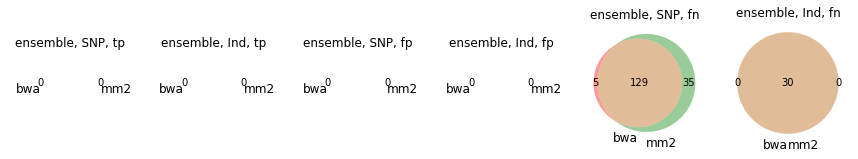

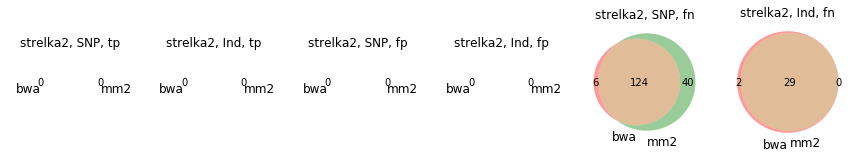

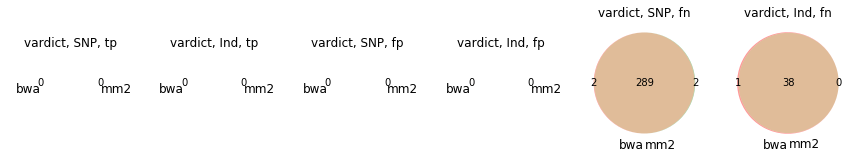

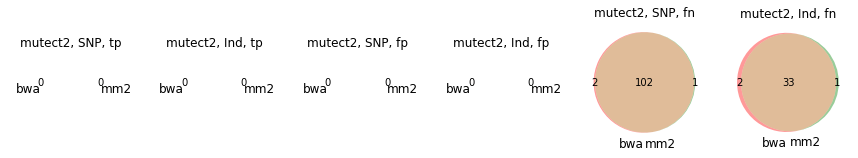

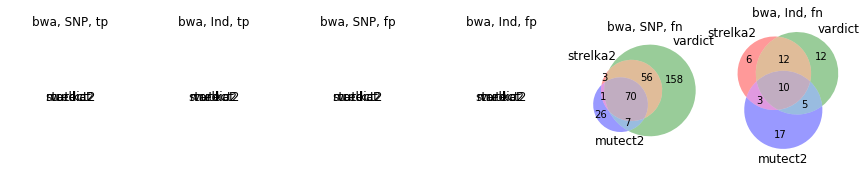

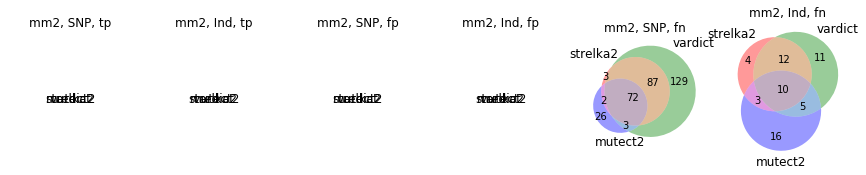

In [223]:
from matplotlib_venn import venn2, venn3
from matplotlib import gridspec
import itertools

def plot_venn(bn, df=None):
    """                   tp-snp  tp-ind  fp-snp  fp-ind  fn-snp  fn-ind    
        mm2/bwa ensemble
        mm2/bwa strelka2 
        mm2/bwa mutect2 
        mm2/bwa vardict
        v/s/m bwa  
        v/s/m mm2            
    """    
    b = benchmark_d[bn]
    df = df if (df is not None) else benchmark_d[bn]['df']
    figsize = (15, 15)

    event_types = [True, False]  # SNP, non-SNP
    
    # 2-way BWA vs Minimap2, one raw for each caller
    for clr_i, clr in enumerate(b['callers']):
        fig = plt.figure(figsize=figsize)
        plt.title(f'BWA vs minimap2 calls for {clr}')
        grid = gridspec.GridSpec(1, len(event_types)*3)
        for is_snp_i, is_snp in enumerate(event_types):
            lbl = 'SNP' if is_snp else 'Ind'
            for typ_i, typ in enumerate(['tp', 'fp', 'fn']):
                ax = plt.subplot(grid[len(event_types)*typ_i + is_snp_i])
                sets = [set(df.query(f'{aln}_t == "{typ}" & caller == "{clr}" & is_snp == {is_snp}').index.tolist())
                        for aln in ['bwa', 'mm2']]                
                venn2(sets, set_labels=['bwa', 'mm2'], ax=ax)
                ax.set_title(f'{clr}, {lbl}, {typ}')
        
    # 3-way strelka2 vs mutect vs vardict, one raw for each aligner
    clrs = [c for c in b['callers'] if c != 'ensemble']   
    for aln in ['bwa', 'mm2']:
        fig = plt.figure(figsize=figsize)
        plt.title(f'Callers against each other for {aln}')
        grid = gridspec.GridSpec(1, len(event_types)*3)
        for is_snp_i, is_snp in enumerate(event_types):
            lbl = 'SNP' if is_snp else 'Ind'
            for typ_i, typ in enumerate(['tp', 'fp', 'fn']):
                ax = plt.subplot(grid[len(event_types)*typ_i + is_snp_i])
                sets = [set(df.query(f'{aln}_t == "{typ}" & caller == "{clr}" & is_snp == {is_snp}').index.tolist())
                        for clr in clrs]                
                venn3(sets, set_labels=clrs, ax=ax)
                ax.set_title(f'{aln}, {lbl}, {typ}')

plot_venn('mb', load_vcfs('mb', ['fn']))

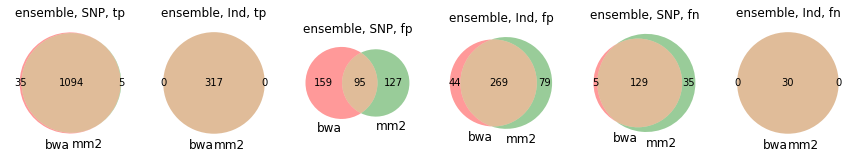

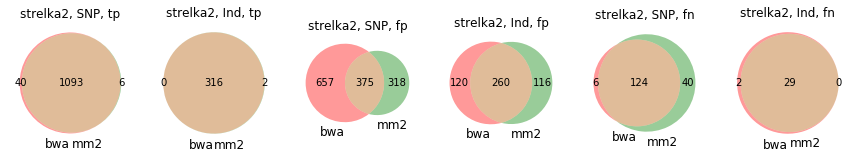

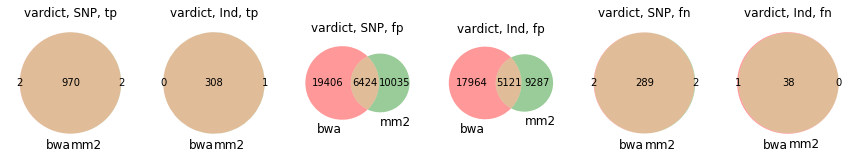

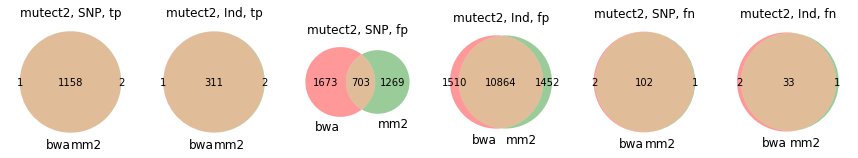

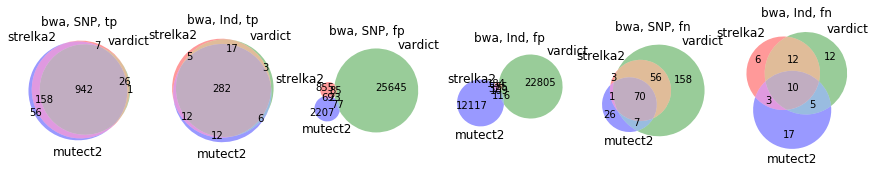

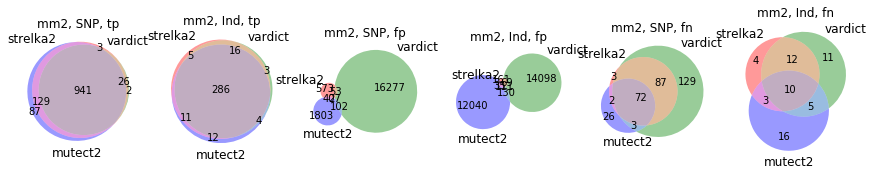

In [288]:
plot_venn('mb')

/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:117: UserWarning:

Bad circle positioning



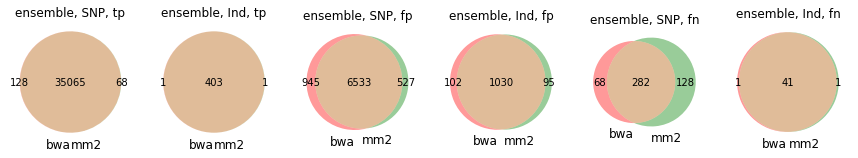

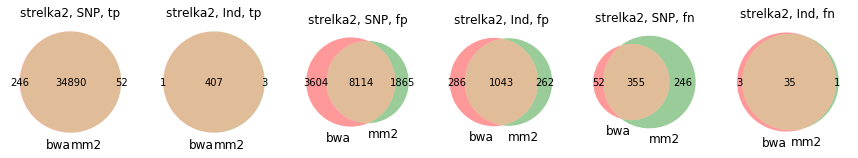

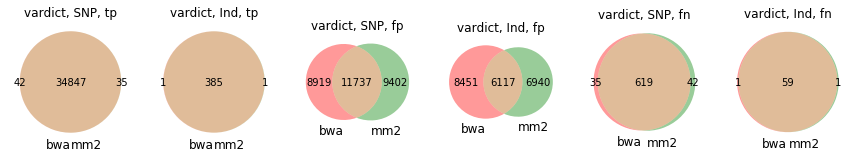

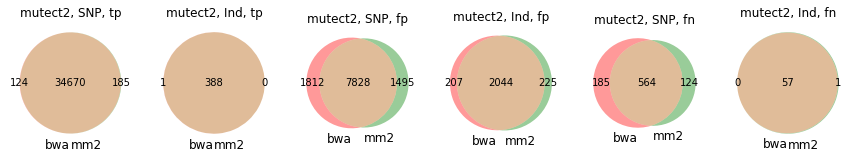

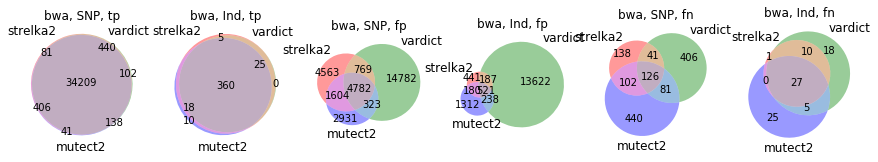

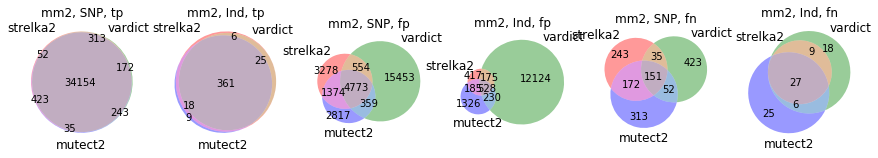

In [289]:
plot_venn('colo')

Loading for benchmark giab
--------------------------
Parsing VCFs for ensemble
  reading giab/eval/UtahMormon-1-bwa-ensemble-annotated_bcftools_isec/0001.vcf
  reading giab/eval/UtahMormon-1-mm2-ensemble-annotated_bcftools_isec/0001.vcf
Analysing data for ensemble, building dataframe
Done parsing 14867 ensemble variants, saved 14867

Parsing VCFs for strelka2
  reading giab/eval/UtahMormon-1-bwa-strelka2-annotated_bcftools_isec/0001.vcf
  reading giab/eval/UtahMormon-1-mm2-strelka2-annotated_bcftools_isec/0001.vcf
Analysing data for strelka2, building dataframe
Done parsing 21169 strelka2 variants, saved 21169

Parsing VCFs for vardict
  reading giab/eval/UtahMormon-1-bwa-vardict-annotated_bcftools_isec/0001.vcf
  reading giab/eval/UtahMormon-1-mm2-vardict-annotated_bcftools_isec/0001.vcf
Analysing data for vardict, building dataframe
Done parsing 58246 vardict variants, saved 58246

Parsing VCFs for gatk-haplotype
  reading giab/eval/UtahMormon-1-bwa-gatk-haplotype-annotated_bcftools

/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/matplotlib_venn/_venn2.py:50: UserWarning:

Both circles have zero area

/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:47: UserWarning:

All circles have zero area



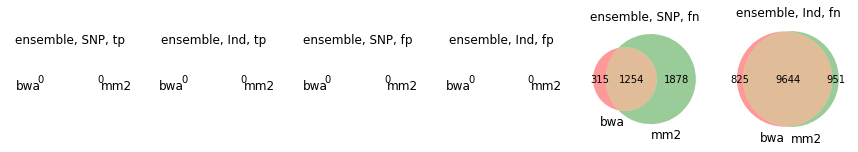

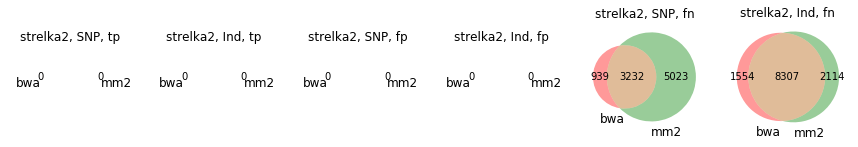

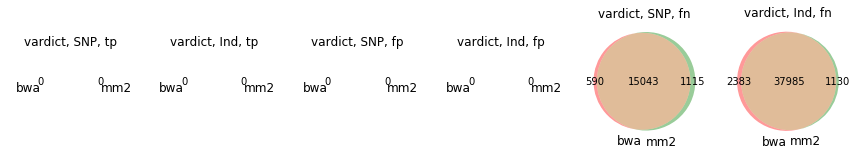

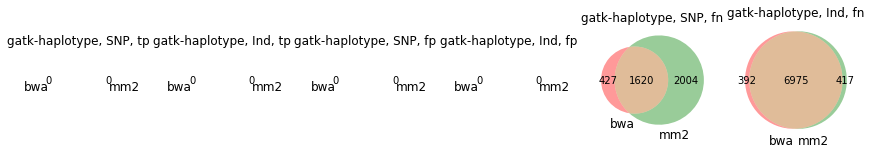

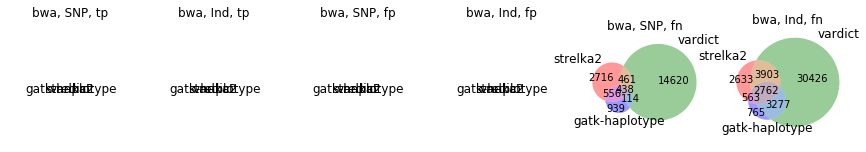

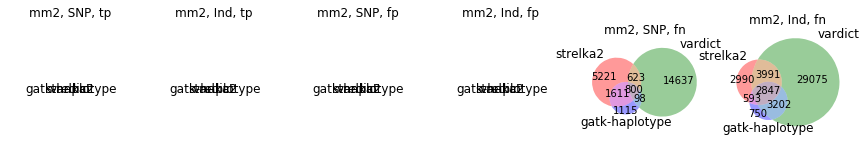

In [224]:
plot_venn('giab', load_vcfs('giab', ['fn']))

In [273]:
# Getting minimap2 data for unique Strelka2+BWA FP
tp_bwa_strelka_by_bn = {
    bn: benchmark_d[bn]['df'].query('caller == "strelka2" & is_snp & bwa_t == "tp" & mm2_t != "tp"')
    for bn in ['mb', 'colo']
}

In [274]:
import tabix
import IPython.core.debugger
dbg = IPython.core.debugger.Pdb()

for bn, df in tp_bwa_strelka_by_bn.items():
    chrom_pos = list(zip(df['chrom'].tolist(), df['pos'].tolist()))
    print(f'Failed mm2 positions called with bwa, total {len(chrom_pos)} in {bn}')

    with open(f'{bn}_strelka_snp_uniq_fn.bed', 'w') as f:
        for chrom, pos in chrom_pos:
            f.write(f'{chrom}\t{pos-1}\t{pos}\n')

#     tb = tabix.open(strelka_original_vcf_by_bn[bn])
#     for chrom, pos in chrom_pos:
#         recs = list(tb.query(chrom, pos-1, pos))
#         rec = recs[0] if recs else None
#         if not rec:
#             print(f'No failed rec for {chrom}:{pos}')
#         else:
#             info = dict((v.split(':') if ':' in v else (v, None)) for v in rec[7].split(';'))
        
#             for tag in ['AF', 'DP', 'MQ']:
#                 for ph in ['TUMOR', 'NORMAL']:
#                     v = info.get(f'{ph}_{tag}')
#                     df[f'mm2_{ph}_{tag}'] = v
#                     dbg.set_trace()

#             df[f'mm2_SomaticEVS'] = info.get('SomaticEVS')
#             df[f'mm2_ReadPosRankSum'] = info.get('ReadPosRankSum')

!bcftools view mb/batch1-strelka2-annotated-mm2.vcf.gz -R mb_strelka_snp_uniq_fn.bed -Oz -o strelka_snp_uniq_fn/mb_strelka_snp_uniq_fn.vcf.gz
!bcftools view colo/COLO_TGEN_mm2-strelka2-annotated.vcf.gz -R colo_strelka_snp_uniq_fn.bed -Oz -o strelka_snp_uniq_fn/colo_strelka_snp_uniq_fn.vcf.gz
!pcgr_prep strelka_snp_uniq_fn/mb_strelka_snp_uniq_fn.vcf.gz | bgzip -c > strelka_snp_uniq_fn/mb_strelka_snp_uniq_fn.annotated.vcf.gz
!pcgr_prep strelka_snp_uniq_fn/colo_strelka_snp_uniq_fn.vcf.gz | bgzip -c > strelka_snp_uniq_fn/colo_strelka_snp_uniq_fn.annotated.vcf.gz
!tabix strelka_snp_uniq_fn/mb_strelka_snp_uniq_fn.annotated.vcf.gz
!tabix strelka_snp_uniq_fn/colo_strelka_snp_uniq_fn.annotated.vcf.gz

tp_bwa_strelka_vcf_by_bn = {
    'mb': 'strelka_snp_uniq_fn/mb_strelka_snp_uniq_fn.annotated.vcf.gz',
    'colo': 'strelka_snp_uniq_fn/colo_strelka_snp_uniq_fn.annotated.vcf.gz',
}

for bn, df in tp_bwa_strelka_by_bn.items():
    chrom_pos = list(zip(df['chrom'].tolist(), df['pos'].tolist()))
    print(f'Filling up mm2 fields in {bn} from VCF {vcf_by_bn[bn]}')
    vcf = VCF(tp_bwa_strelka_vcf_by_bn[bn])
    for rec in vcf:
        fs = rec_to_fields(rec, 'mm2', 'strelka2')
        label = f'{rec.CHROM}:{rec.POS}-{rec.REF}>{rec.ALT[0]}'
        for k, v in fs.items():
            df.loc[label,k] = v

#     for chrom, pos in chrom_pos:
#         recs = list(tb.query(chrom, pos-1, pos))
#         rec = recs[0] if recs else None
#         if not rec:
#             print(f'No failed rec for {chrom}:{pos}')
#         else:
#             info = dict((v.split(':') if ':' in v else (v, None)) for v in rec[7].split(';'))
        
#             for tag in ['AF', 'DP', 'MQ']:
#                 for ph in ['TUMOR', 'NORMAL']:
#                     v = info.get(f'{ph}_{tag}')
#                     df[f'mm2_{ph}_{tag}'] = v
#                     dbg.set_trace()

#             df[f'mm2_SomaticEVS'] = info.get('SomaticEVS')
#             df[f'mm2_ReadPosRankSum'] = info.get('ReadPosRankSum')

Failed mm2 positions called with bwa, total 40 in mb
Failed mm2 positions called with bwa, total 246 in colo
Filling up mm2 fields in mb from VCF mb_strelka_snp_uniq_fn.normalised.vcf.gz


/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Filling up mm2 fields in colo from VCF colo_strelka_snp_uniq_fn.normalised.vcf.gz


/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [285]:
# Getting only strelka2 unique FN SNPs
small_dfs = dict()
for bn in 'mb', 'colo':
    v = VCF(f'strelka_snp_uniq_fn/{bn}_strelka_snp_uniq_fn.vcf.gz')
    coords = set([(r.POS) for r in v])
    print(len(coords))
    sdf = benchmark_d[bn]['df']
    sdf = sdf[sdf['pos'].isin(coords)]
    print(len(sdf))
    small_dfs[bn] = sdf

40
160
231
926


/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/matplotlib_venn/_venn2.py:50: UserWarning:

Both circles have zero area

/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:47: UserWarning:

All circles have zero area

/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:53: UserWarning:

Circle A has zero area

/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:117: UserWarning:

Bad circle positioning



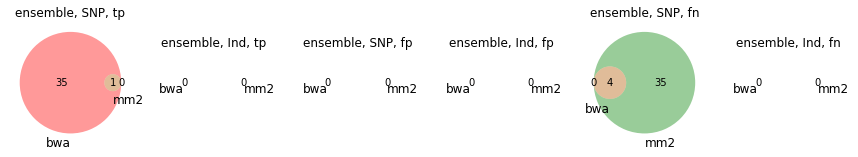

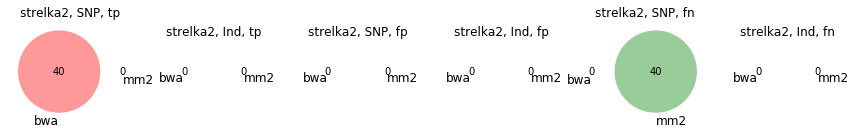

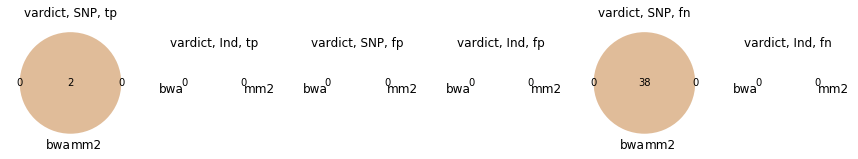

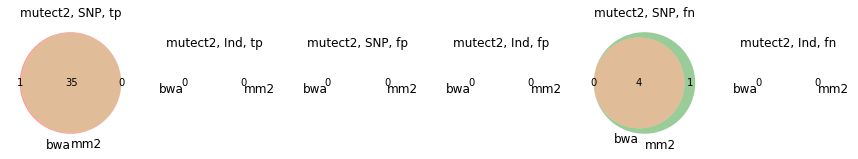

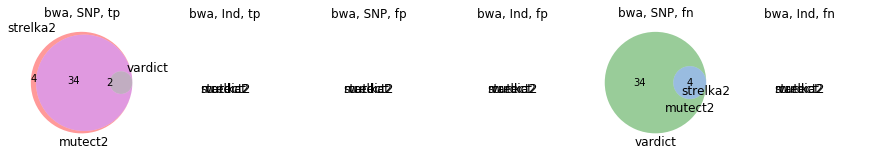

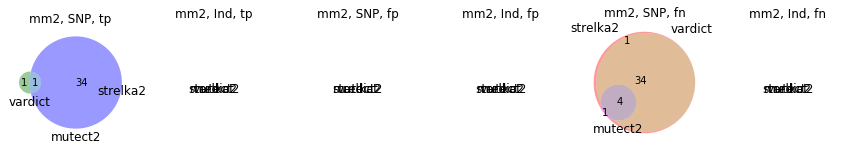

In [286]:
plot_venn('mb', small_dfs['mb'])

/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/matplotlib_venn/_venn2.py:50: UserWarning:

Both circles have zero area

/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:117: UserWarning:

Bad circle positioning

/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:47: UserWarning:

All circles have zero area

/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:53: UserWarning:

Circle A has zero area

/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:57: UserWarning:

Circle B has zero area

/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:61: UserWarning:

Circle C has zero area



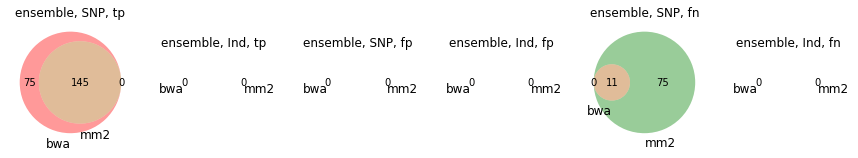

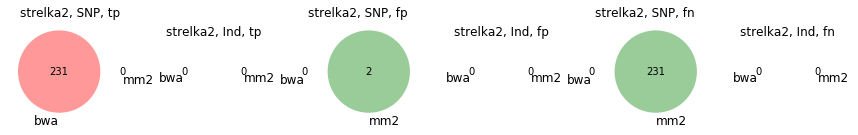

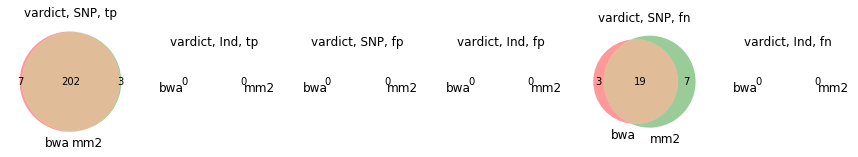

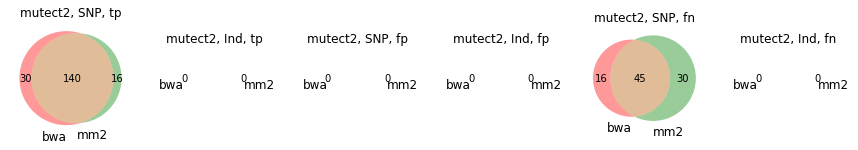

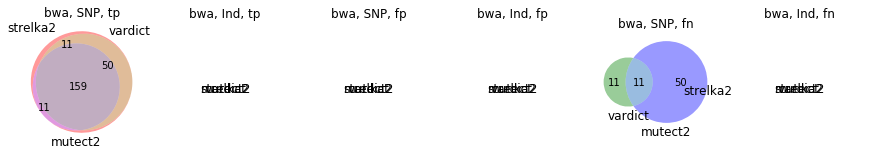

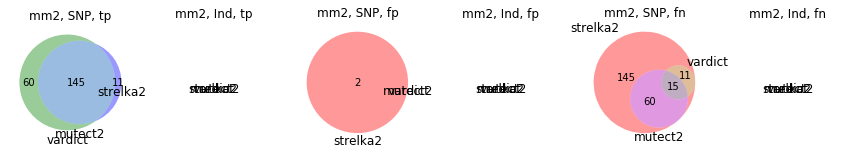

In [279]:
plot_venn('colo', small_dfs['colo'])

mb: Average _TUMOR_DP difference 2.825
colo: Average _TUMOR_DP difference 20.56768558951965
mb: Average _TUMOR_AF difference 0.010850563971325755
colo: Average _TUMOR_AF difference 0.00591222055288902
mb: Average _TUMOR_MQ difference 0.9969997406005859
colo: Average _TUMOR_MQ difference 2.7265502188403534
mb: Average _ReadPosRankSum difference -0.03550000251270831
colo: Average _ReadPosRankSum difference -0.0864628800333327
mb: Average _SomaticEVS difference 3.3625000447034834
colo: Average _SomaticEVS difference 3.830043668439815


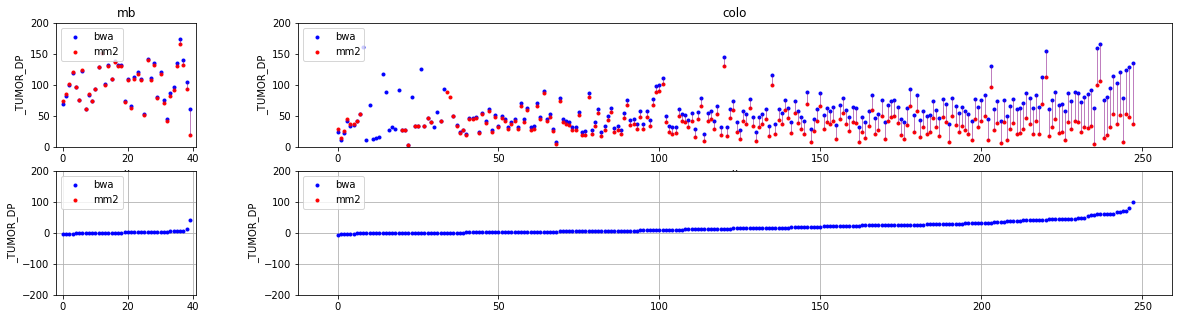

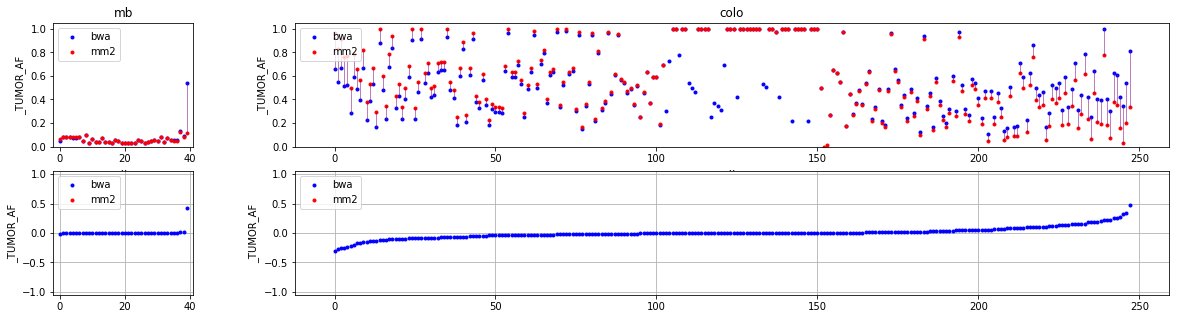

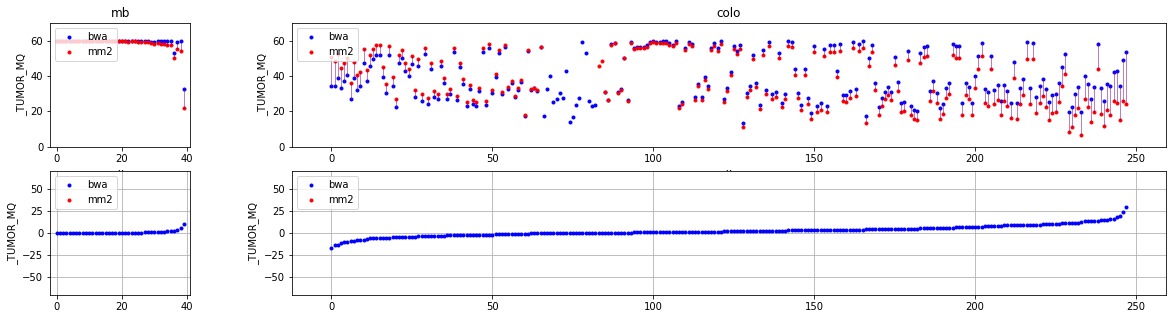

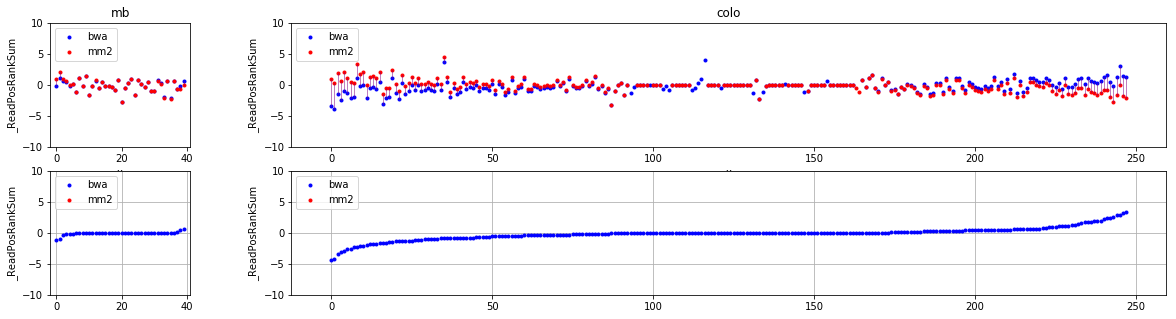

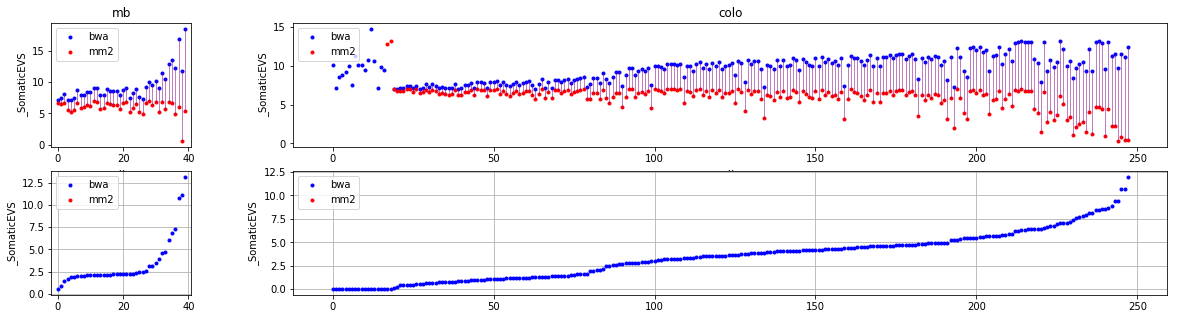

In [358]:
# For unique Strelka2+BWA FP, plotting differences with minimap2
from matplotlib import gridspec
import pandas as pd
import numpy as np
import math

bright_colors = ['blue', 'red', 'green']
pale_colors = ['lightblue', 'pink', 'lightgreen']

for field, ylim in [
        ('_TUMOR_DP',       (0, 200  )), 
        ('_TUMOR_AF',       (0, 1.05 )),
        ('_TUMOR_MQ',       (0, 70   )),
        ('_ReadPosRankSum', (-10, 10 )),
        ('_SomaticEVS',     None),
    ]:
    fig = plt.figure(figsize=(20, 5))
    grid = gridspec.GridSpec(2, 2, width_ratios=[40, 250])

    for i, (bn, df) in enumerate(tp_bwa_strelka_by_bn.items()):
        ax = plt.subplot(grid[i], label=bn)
        ax_diff = plt.subplot(grid[2+i], label=bn)
        values = [df[aln + field].reset_index(drop=True).values for aln in ['bwa', 'mm2']]
        diffs = [v1 - v2 for v1, v2 in zip(*values)]
        values.append([d if not math.isnan(d) else 0 for d in diffs])
        value_triplets = list(zip(*values))
        value_triplets = sorted(value_triplets, key=lambda v: v[2] if not math.isnan(v2) else 0)
#         if i == 1 and field == '_TUMOR_DP':
#             for t in value_triplets:
#                 print(t)
        values = list(zip(*value_triplets))

        for j, aln in enumerate(['bwa', 'mm2']):
            ax.plot(values[j], '.', c=bright_colors[j], label=f'{aln}')
        ax_diff.plot(values[2], '.', c='blue', label=f'bwa - mm2')

        diffs = [x for x in diffs if not math.isnan(x)]
        print(f'{bn}: Average {field} difference {np.mean(diffs)}')

        for x, (v1, v2, diff) in enumerate(value_triplets):
            line_clr = None
            if v1 is not None and v2 is not None:
                line_clr = 'purple'
            elif d1 is not None:
                line_clr = 'red'
            elif d2 is not None:
                line_clr = 'blue'
            ax.plot([x, x], [v1, v2], '-', c=line_clr, lw=0.5)

        ax.set_xlabel('x')
        ax.set_ylabel(field)
        ax.set_title(label=bn)
        if ylim:
            ax.set_ylim(ylim)
        ax.legend(*ax.get_legend_handles_labels(), loc=2)

        ax_diff.set_label('x')
        ax_diff.set_ylabel(field)
        if ylim:
            ax_diff.set_ylim((-ylim[1], ylim[1]))
        ax_diff.legend(*ax.get_legend_handles_labels(), loc=2)

        plt.grid()

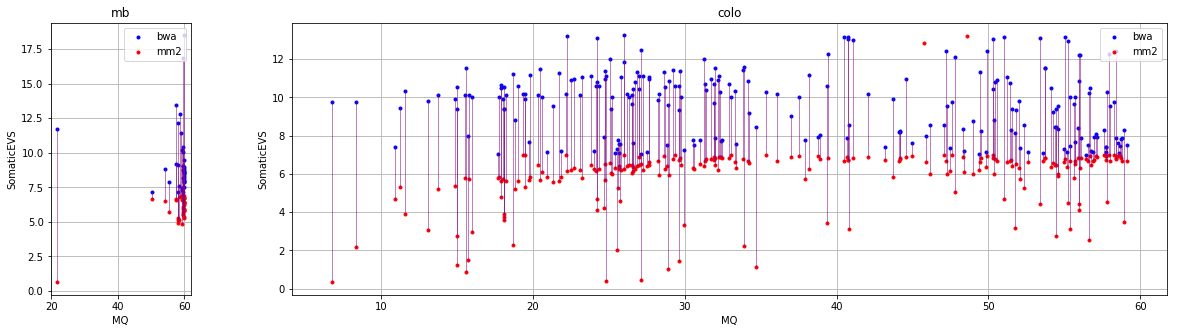

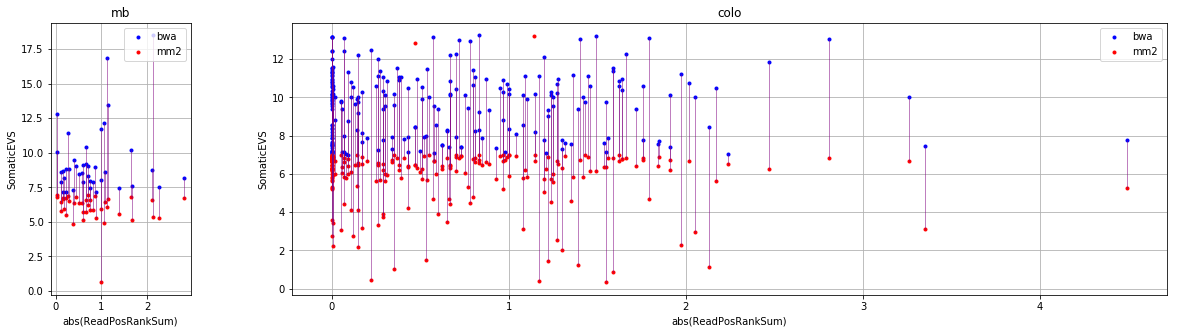

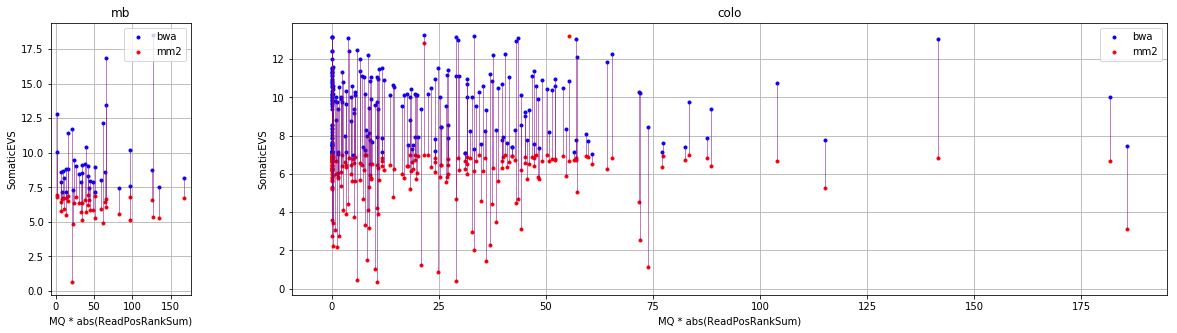

In [188]:
# For unique Strelka2+BWA FP, plotting differences with minimap2
from matplotlib import gridspec
import pandas as pd
import numpy as np

for get_xs_df, xlabel in [
    (lambda d: d[f'{aln}_TUMOR_MQ'],                                   'MQ'),
    (lambda d: abs(d[f'{aln}_ReadPosRankSum']),                        'abs(ReadPosRankSum)'),
    (lambda d: d[f'{aln}_TUMOR_MQ'] * abs(d[f'{aln}_ReadPosRankSum']), 'MQ * abs(ReadPosRankSum)'),
]:
    fig = plt.figure(figsize=(20, 5))
    grid = gridspec.GridSpec(1, 2, width_ratios=[40, 250])
    for i, bn in enumerate(df_by_benchmark):
        df = by_bn[bn]
        ax = plt.subplot(grid[i], label=bn)

        xss = [get_xs_df(df).tolist() for aln in ['bwa', 'mm2']]
        yss = [df[f'{aln}_SomaticEVS'].tolist() for aln in ['bwa', 'mm2']]

        for j, aln in enumerate(['bwa', 'mm2']):
            ax.plot(xss[j], yss[j], '.', c=bright_colors[j], label=f'{aln}')

        for x, ((x1, x2), (y1, y2)) in enumerate(zip(list(zip(*xss)), list(zip(*yss)))):
            line_clr = None
            if d1 is not None and d2 is not None:
                line_clr = 'purple'
            elif d1 is not None:
                line_clr = 'red'
            elif d2 is not None:
                line_clr = 'blue'
            ax.plot([x1, x2], [y1, y2], '-', c=line_clr, lw=0.5)
        ax.set_xlabel(xlabel)
        ax.set_ylabel('SomaticEVS')
        ax.set_title(label=bn)
        ax.legend(*ax.get_legend_handles_labels(), loc=1)
        plt.grid()

In [92]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from plotly.figurefactory 

init_notebook_mode(connected=True)

df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/school_earnings.csv")

table = ff.create_table(df)
iplot(table)

In [5]:
# Defining plotting functions

## Prepare colors for variant vs coordinate plots
from matplotlib.ticker import LinearLocator
from matplotlib import rc, font_manager

stats_by_cat_by_chrom = defaultdict(Counter)
for (caller, is_snp, category, chrom), g in df.groupby(['caller', 'is_snp', 'category', 'chrom']):
    stats_by_cat_by_chrom[(caller, is_snp, category)][chrom] += len(g)

def get_colors(category):
    """ Return color of BWA dot, color of minimap2 dot, and color of line connecting dots
    """
    if   category == ('tp', 'tp'):  return 'purple',    'purple', 'purple'
    elif category == ('tp', 'fn'):  return 'blue',       None,     None
    elif category == ('fp', 'fp'):  return 'violet',    'violet', 'violet'
    elif category == ('fp', 'tn'):  return 'lightblue',  None,     None
    elif category == ('fn', 'tp'):  return  None,       'red',     None
    elif category == ('fn', 'fn'):  return 'green',      None,     None
    elif category == ('tn', 'fp'):  return  None,       'pink',    None
    else:                           return  None,        None,     None

## Plotting chromosome ticks
def draw_ticks(ax, chrom=None):
    chrom_poss = chrom_positions
    if chrom:
        chrom_poss = [(c, p) for c, p in chrom_positions if c in [str(chrom), int_to_chrom(chrom_to_int(chrom) + 1)]]

    ax.set_xlim([chrom_poss[0][1], chrom_poss[-1][1]])
    
    return chrom_poss
    
def _get_category(x):
    return {
        ('tp', 'fn'): 'unique_tp_bwa',
        ('fn', 'tp'): 'unique_tp_mm2',
        ('fp', 'tn'): 'unique_fp_bwa',
        ('tn', 'fp'): 'unique_fp_mm2',  
        ('tp', 'tp'): 'common_tp',
        ('fp', 'fp'): 'common_fp',
        ('fn', 'fn'): 'common_fn'
    }[(x['bwa_t'], x['mm2_t'])]
    
## Plotting data
def plot(caller, field, field_name=None, chrom=None, max_y=None, count_tricky_anno=True):
    print(f'Plotting {field} for {caller} by coordinate')
    dfc = df[df['caller'] == caller]
    dfc['category'] = dfc.apply(_get_category, axis=1)
    
    field_name = field_name or field.upper()

    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(111, label=f'{caller}_{field}', 
                         title=f'{field_name} for variant calls from BWA (blue) vs. minimap2 (red) alignments')
    chrom_poss = draw_ticks(ax, chrom)
    
    modify = modify_back = lambda v: v
    if max_y:
        modify = lambda v: max_y+( - max_y)/10 if v > max_y else v
        modify_back = lambda v: max_y+(v-max_y)*10 if v > max_y else v
    
    groupby = ['bwa_t', 'mm2_t']
    if count_tricky_anno:
        groupby.append('tricky_anno')

    # Plotting dots
    for category, g in dfc.groupby(groupby):
        print(f'  plotting category {category}, size {len(g)}')
#        assert 'bwa' in g.field_by_aligner, len(g.field_by_aligner)
#        assert 'mm2' in g.field_by_aligner, g.field_by_aligner
        bwa_validate, mm2_validate = category[:2]
        tricky_anno = category[2] if count_tricky_anno else None
        print(f'  calculating colors')
        bwa_color, mm2_color, line_color = get_colors((bwa_validate, mm2_validate))
        print(f'  modifying')
        try:
            bys = g[f'bwa_{field}'].map(modify)
        except:
            raise
        mys = g[f'mm2_{field}'].map(modify)
        marker = 'x' if tricky_anno else '.'
        print(f'  scattering')
        if bwa_color:
            ax.scatter(g['x'], bys, marker=marker, color=bwa_color)
        if mm2_color:
            ax.scatter(g['x'], mys, marker=marker, color=mm2_color)
        if line_color:
            print(f'  plotting lines')
            for index, row in g.iterrows():
                by = modify(row[f'bwa_{field}'])
                my = modify(row[f'mm2_{field}'])
                ax.plot([row['x'], row['x']], [by, my], color=line_color, linewidth=1)
    
    s = stats_by_cat_by_chrom
    def _make_lbl(c):
        cs = dict(
            c_snp_t = s[caller, True, "common_tp"][c],
            c_ind_t = s[caller, False, "common_tp"][c],
            c_snp_f = s[caller, True, "common_fp"][c],
            c_ind_f = s[caller, False, "common_fp"][c],
            b_snp_t = s[caller, True, "unique_tp_bwa"][c],
            b_ind_t = s[caller, False, "unique_tp_bwa"][c],
            b_snp_f = s[caller, True, "unique_fp_bwa"][c],
            b_ind_f = s[caller, False, "unique_fp_bwa"][c],
            m_snp_t = s[caller, True, "unique_tp_mm2"][c],
            m_ind_t = s[caller, False, "unique_tp_mm2"][c],
            m_snp_f = s[caller, True, "unique_fp_mm2"][c],
            m_ind_f = s[caller, False, "unique_fp_mm2"][c],
        )
        max_snp_len = max([len(str(v)) for k, v in cs.items() if 'snp' in k])
        max_ind_len = max([len(str(v)) for k, v in cs.items() if 'ind' in k])
            
        if c == '1':
            return '\n'.join([f'{c}', 
                              f'Common   T {cs["c_snp_t"]:{max_snp_len}}+{cs["c_ind_t"]:{max_ind_len}} ',
                              f'         F {cs["c_snp_f"]:{max_snp_len}}+{cs["c_ind_f"]:{max_ind_len}}', 
                              f'BWA uniq T {cs["b_snp_t"]:{max_snp_len}}+{cs["b_ind_t"]:{max_ind_len}} ',
                              f'         F {cs["b_snp_f"]:{max_snp_len}}+{cs["b_ind_f"]:{max_ind_len}}', 
                              f'MM2 uniq T {cs["m_snp_t"]:{max_snp_len}}+{cs["m_ind_t"]:{max_ind_len}} ',
                              f'         F {cs["m_snp_f"]:{max_snp_len}}+{cs["m_ind_f"]:{max_ind_len}}', 
                              ])
        else:
            return '\n'.join([f'{c}', 
                              f'{cs["c_snp_t"]:{max_snp_len}}+{cs["c_ind_t"]:{max_ind_len}} ',
                              f'{cs["c_snp_f"]:{max_snp_len}}+{cs["c_ind_f"]:{max_ind_len}}', 
                              f'{cs["b_snp_t"]:{max_snp_len}}+{cs["b_ind_t"]:{max_ind_len}} ',
                              f'{cs["b_snp_f"]:{max_snp_len}}+{cs["b_ind_f"]:{max_ind_len}}', 
                              f'{cs["m_snp_t"]:{max_snp_len}}+{cs["m_ind_t"]:{max_ind_len}} ',
                              f'{cs["m_snp_f"]:{max_snp_len}}+{cs["m_ind_f"]:{max_ind_len}}', 
                              ])
    
    print('Setting ticks...')
    plt.xticks([pos for c, pos in chrom_poss], 
               [_make_lbl(c) if c else '' for c, _ in chrom_poss],
              horizontalalignment='left',
              fontproperties=font_manager.FontProperties(family='monospace'))
    
    if max_y:
        print(f'Limiting Y by {max_y}...')
        ax.set_yticklabels([modify_back(l) for l in ax.get_yticks().tolist()])
        ax.plot([0, dfc['x'].max()], [max_y, max_y], color='black', linestyle='--', linewidth=1)

#         grouped = df.groupby('zorder')
#         for zorder, g in grouped:
#             ax.scatter(g['x'], g[f'bwa_{field}'].map(modify), marker='.', color=g['color'], zorder=zorder)
#             ax.scatter(g['x'], g[f'mm2_{field}'].map(modify), marker='.', color=g['color'], zorder=zorder)

    print(f'Limiting X...')
    ax.set_xlim([chrom_poss[0][1], chrom_poss[-1][1]])
    plt.grid()
    
    return dfc, ax

#plot('strelka2', 'TUMOR_DP', max_y=300)
#plot('strelka2', 'NORMAL_DP', max_y=300)
pass

In [ ]:
plot('strelka2', 'TUMOR_DP', max_y=300, count_tricky_anno=False)
plot('strelka2', 'NORMAL_DP', max_y=300, count_tricky_anno=False)
pass

Plotting TUMOR_DP for strelka2 by coordinate
  plotting category ('fn', 'fn'), size 390
  plotting category ('fn', 'tp'), size 55
  plotting category ('fp', 'fp'), size 5356
  plotting category ('fp', 'tn'), size 3184
  plotting category ('tn', 'fp'), size 1766
  plotting category ('tp', 'fn'), size 232
  plotting category ('tp', 'tp'), size 34955


KeyboardInterrupt: 

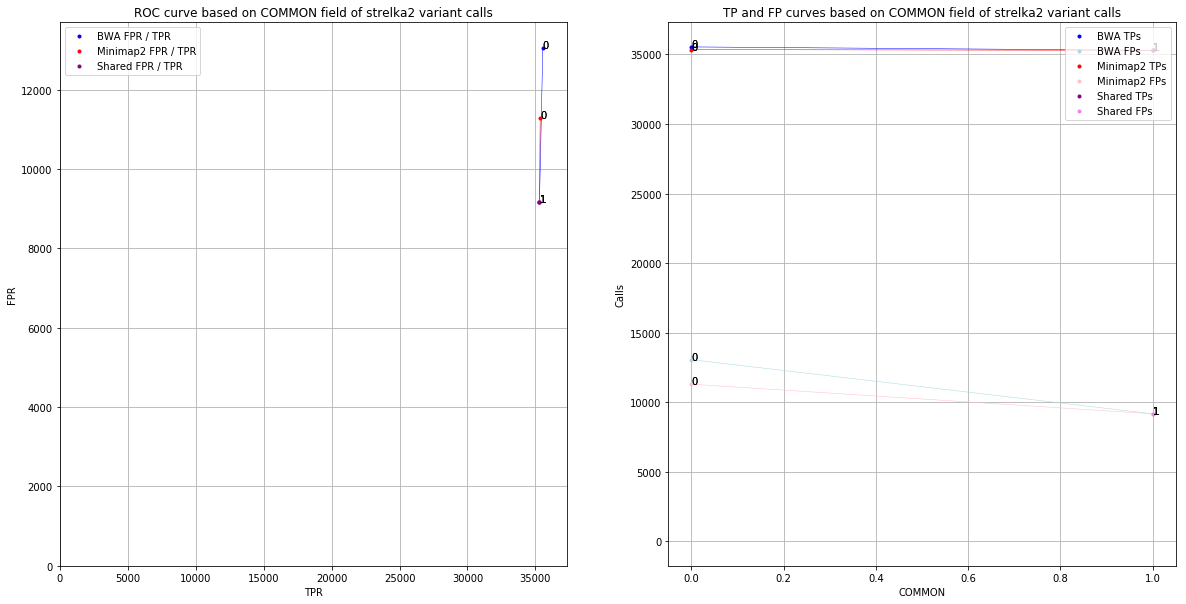

In [27]:
# Defining function for plotting ROC and TP/FP ratios curves

from matplotlib import gridspec
from matplotlib.transforms import blended_transform_factory

def plot_roc(caller, field, start, end, step=1, label_step=5, show_values=False, filt_fn=None):
    dfc = df[df['caller'] == caller]
    if filt_fn:
        dfc = dfc[df.apply(filt_fn, axis=1)]

    fig = plt.figure(figsize=(20, 10))
    grid = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    roc_ax = plt.subplot(grid[0], 
         label=f'ROC {caller} {field.upper()}', 
         title=f'ROC curve based on {field.upper()} field of {caller} variant calls')
    roc_ax.set_xlabel('TPR')
    roc_ax.set_ylabel('FPR')
    plt.grid()
    tp_fp_ax = plt.subplot(grid[1], 
         label=f'TP and FP {caller} {field.upper()}', 
         title=f'TP and FP curves based on {field.upper()} field of {caller} variant calls')  
    tp_fp_ax.set_xlabel(f'{field.upper()}')
    tp_fp_ax.set_ylabel('Calls')
    plt.grid()
    
    # Pre-calculation    
    max_tp = 0
    max_fp = 0
    tps_by_aln = defaultdict(list)
    fps_by_aln = defaultdict(list)
    for aln in ['bwa', 'mm2']:
        vals = np.arange(start, end + step, step)
        for val in vals:
            val_data = dfc[dfc[aln + '_' + field] >= val]
            
            tp = len(val_data[val_data[f'{aln}_t'] == 'tp'])
            fn = len(val_data[val_data[f'{aln}_t'] == 'fn'])
            fp = len(val_data[val_data[f'{aln}_t'] == 'fp'])
            
            tps_by_aln[aln].append(tp)
            fps_by_aln[aln].append(fp)
    
    max_tp = max(max(vs) for vs in tps_by_aln.values())
    max_fp = max(max(vs) for vs in fps_by_aln.values())
    
    com = []
    bwa = []
    mm2 = []
    
    for val, bwa_tp, bwa_fp, mm2_tp, mm2_fp in zip(
        vals, tps_by_aln['bwa'], fps_by_aln['bwa'], tps_by_aln['mm2'], fps_by_aln['mm2']):
        bwa.append([val, bwa_tp, bwa_fp])
        mm2.append([val, mm2_tp, mm2_fp])
        if bwa_tp == mm2_tp and bwa_fp == mm2_fp:
            com.append([val, bwa_tp, bwa_fp])

    # ROC curve plots
    roc_ax.plot([p[1] for p in bwa], [p[2] for p in bwa], '-', c='blue',   lw=0.5)
    roc_ax.plot([p[1] for p in bwa], [p[2] for p in bwa], '.', c='blue',   label=f'BWA FPR / TPR')
    roc_ax.plot([p[1] for p in mm2], [p[2] for p in mm2], '-', c='red',    lw=0.5)
    roc_ax.plot([p[1] for p in mm2], [p[2] for p in mm2], '.', c='red',    label=f'Minimap2 FPR / TPR')
    roc_ax.plot([p[1] for p in com], [p[2] for p in com], '-', c='purple', lw=0.5)
    roc_ax.plot([p[1] for p in com], [p[2] for p in com], '.', c='purple', label=f'Shared FPR / TPR')

    # TP and FP plots        
    tp_fp_ax.plot([p[0] for p in bwa], [p[1] for p in bwa], '-', c='blue',      lw=0.5)
    tp_fp_ax.plot([p[0] for p in bwa], [p[1] for p in bwa], '.', c='blue',      label=f'BWA TPs')
    tp_fp_ax.plot([p[0] for p in bwa], [p[2] for p in bwa], '-', c='lightblue', lw=0.5)
    tp_fp_ax.plot([p[0] for p in bwa], [p[2] for p in bwa], '.', c='lightblue', label=f'BWA FPs') 
    tp_fp_ax.plot([p[0] for p in mm2], [p[1] for p in mm2], '-', c='red',       lw=0.5)
    tp_fp_ax.plot([p[0] for p in mm2], [p[1] for p in mm2], '.', c='red',       label=f'Minimap2 TPs')
    tp_fp_ax.plot([p[0] for p in mm2], [p[2] for p in mm2], '-', c='pink',      lw=0.5) 
    tp_fp_ax.plot([p[0] for p in mm2], [p[2] for p in mm2], '.', c='pink',      label=f'Minimap2 FPs')
    tp_fp_ax.plot([p[0] for p in com], [p[1] for p in com], '.', c='purple',    label=f'Shared TPs')
    tp_fp_ax.plot([p[0] for p in com], [p[2] for p in com], '.', c='violet',    label=f'Shared FPs')

    for aln in ['bwa', 'mm2']:
        for v, fp, tp in com + bwa + mm2:
            label = f'{v}'
            if show_values:
                label += f': {fp}, {tp}'
            if v % label_step == 0:
                roc_ax.annotate(label, xy=(fp, tp))
                tp_fp_ax.annotate(label, xy=(v, tp))
                tp_fp_ax.annotate(label, xy=(v, fp))
                
    delta = max_tp*0.05
    roc_ax.set_xlim([0, max_tp+delta])

    delta = max_fp*0.05
    roc_ax.set_ylim([0, max_fp+delta])
    
    delta = (end-start)*0.05
    tp_fp_ax.set_xlim([start-delta, end+delta])

    max_y = max(max_tp, max_fp)
    delta = max_y*0.05
    tp_fp_ax.set_ylim([-delta, max_y+delta])
      
    roc_ax.legend(*roc_ax.get_legend_handles_labels(), loc=2)
    tp_fp_ax.legend(*tp_fp_ax.get_legend_handles_labels(), loc=1)

def _is_common(x):
    return 1 if (x['called_with_bwa'] and x['called_with_mm2']) else 0
    
df['bwa_common'] = df.apply(_is_common, axis=1)
df['mm2_common'] = df.apply(_is_common, axis=1)

plot_roc('strelka2', 'common', start=0, end=1, step=1, label_step=1, show_values=False)
pass

/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


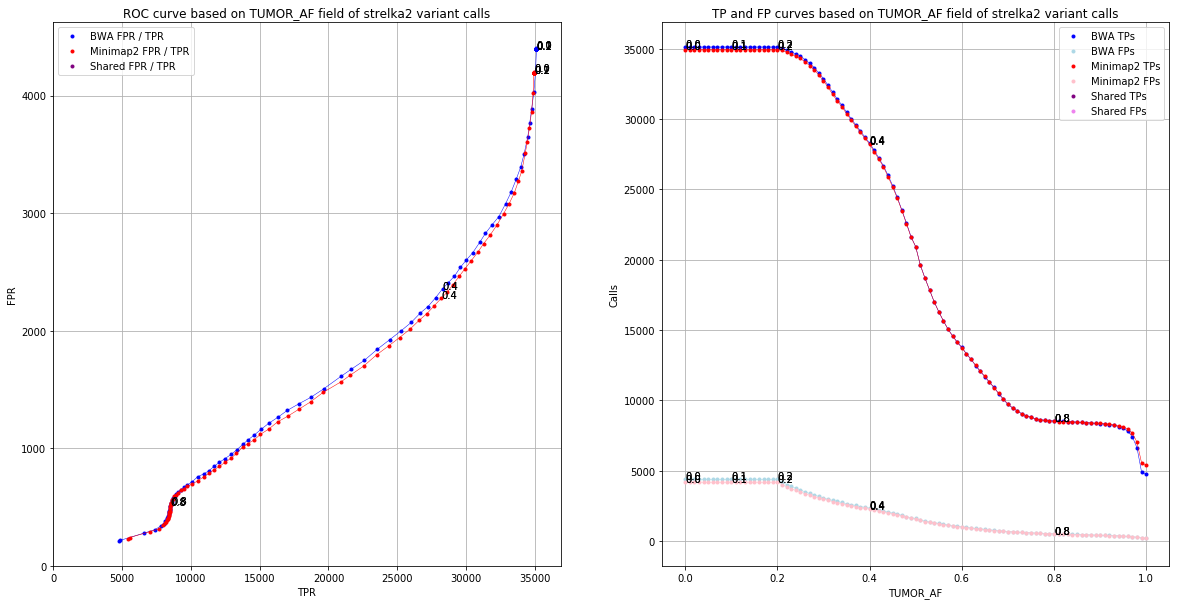

In [28]:
# Strelka2 SomaticEVS ROC curve
def filt_fn(v):
    r = True
    if v['bwa_TUMOR_AF'] and v['bwa_TUMOR_AF'] < 0.2:
        r = False
    if v['bwa_TUMOR_DP'] and v['bwa_TUMOR_DP'] < 23:
        r = False
    if v['mm2_TUMOR_AF'] and v['mm2_TUMOR_AF'] < 0.2:
        r = False
    if v['mm2_TUMOR_DP'] and v['mm2_TUMOR_DP'] < 23:
        r = False
    return r
       
plot_roc('strelka2', 'TUMOR_AF', start=0, end=1, step=0.01, label_step=0.1, show_values=False, filt_fn=filt_fn)
pass

In [ ]:
       
# Strelka2 SomaticEVS ROC curve
plot_roc('strelka2', 'TUMOR_AF', start=0, end=1, step=0.01, label_step=0.1, show_values=False)
pass

In [ ]:
dfc = df[df['caller'] == 'strelka2']
d = dfc[dfc['called_with_mm2'] == True]

import seaborn as sns
sns.set(rc={'figure.figsize':(15, 10)})

pd.set_option('display.max_columns', None)
g2 = sns.jointplot(x="mm2_TUMOR_AF", y="mm2_TUMOR_DP", data=d, kind="kde", kde_kws={'clip':((0, 1), (0, 200))});
#g2.set(xlim=(0, 1), ylim=(0, 200))
#g = sns.distplot(dfc_mm2['mm2_TUMOR_AF'][1000:], rug=True, bins=50)
#g.set(xlim=(0, 1))


In [ ]:
# Strelka2 SomaticEVS ROC curve
plot_roc('strelka2', 'SomaticEVS', 0, 10, 0.1)
pass

In [ ]:
# Strelka2 SomaticEVS ROC curve
plot_roc('strelka2', 'ReadPosRankSum', 0, 4, 0.1)
pass

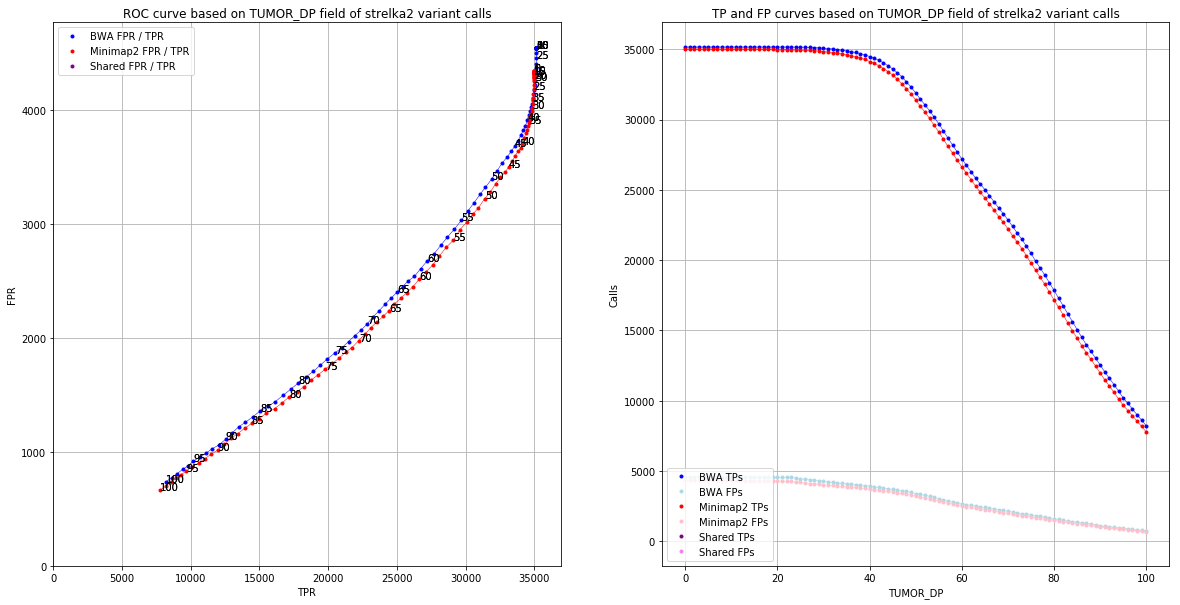

In [12]:
# Strelka2 DP ROC curve
plot_roc('strelka2', 'TUMOR_DP', 0, 100, 1)
pass

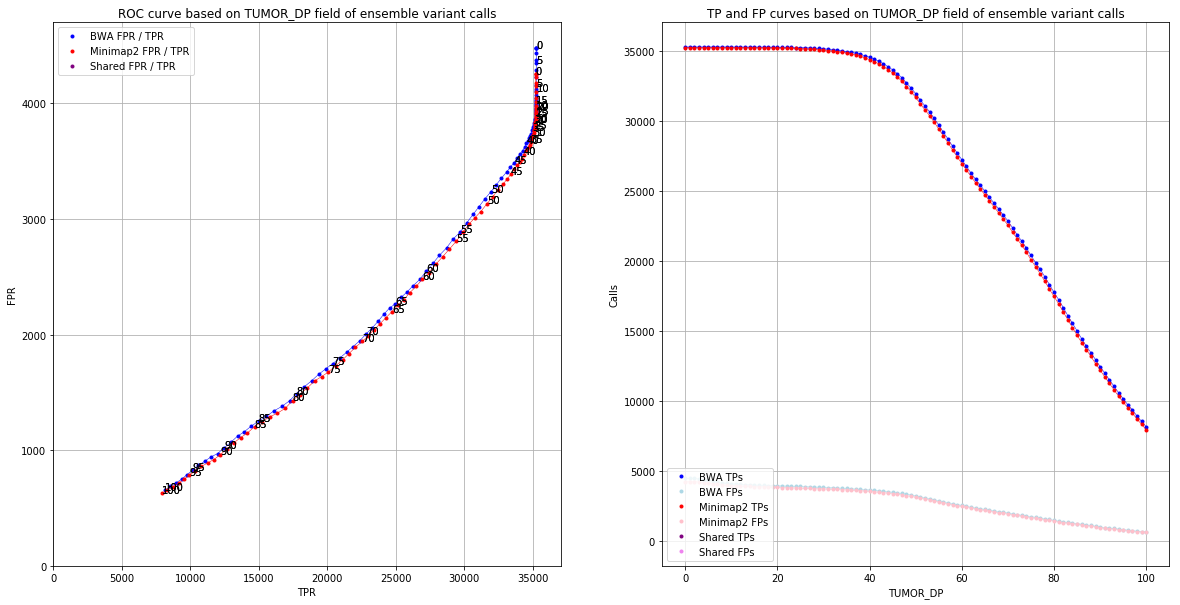

In [7]:
# Strelka2 DP ROC curve
plot_roc('ensemble', 'TUMOR_DP', 0, 100, 1)
pass

In [ ]:
# Strelka2 DP ROC curve
plot_roc('strelka2', 'TUMOR_MQ', 1, 60, 1)
pass

In [ ]:
# Strelka2 DP ROC curve
plot_roc('vardict', 'TUMOR_MQ', 1, 60, 1)
pass

In [ ]:
# Strelka2 DP ROC curve
plot_roc('vardict', 'TUMOR_DP', 1, 100, 1)
pass

In [ ]:
# Strelka2 DP ROC curve
plot_roc('mutect2', 'TUMOR_MQ', 1, 60, 1)
pass

In [ ]:
# Strelka2 DP ROC curve
plot_roc('mutect2', 'TUMOR_DP', 1, 100, 1)
pass

*Plotting variants with X axis as a genome position, and Y axis as a feature (MQ, DP, etc).*
- red dot represent a variant called with minimap2
- blue dot represent a variant called wit BWA
- variants called with both aligners are connected with vertical lines
- pale colors represent false positives, bright colors correspond to true positives
- green dots at the bottom represent shared false negatives (i.e. true variants not called with any aligner)
- those that overlap with low complexity or high/low tricky regions, scatterred with x; others scatterred with .

In [ ]:
plot('strelka2', 'TUMOR_MQ')
#plot('strelka2', 'NORMAL_MQ')
pass

# Annotate dots with gene names:
# for _, r in df[df[f'bwa_mq'] < 20][df[f'bwa_mq'] > 0].iterrows():
#     ax.annotate(r['pos'], xy=(r['x'], r[f'bwa_mq']))
# for _, r in df[df[f'mm2_mq'] < 20][df[f'mm2_mq'] > 0].iterrows():
#     ax.annotate(r['pos'], xy=(r['x'], r[f'mm2_mq']))

# Observations:
# - Chromosome 8: many bwa and minimap FP, but only few are shared.
# 
# TODO: 
# - ROC and other validatiopn stats based on MQ
# - Figure out high depth regions

In [22]:
from ngs_utils.call_process import run

def subset_unique(caller, aligner):
    strelka = df[df['caller'] == caller]
    uniq_tp = strelka[strelka['category'] == f'unique_tp_{aligner}']
    lbls = uniq_tp['label'].tolist()

    inp_vcf = VCF(vcfs[caller][aligner]['tp'])
    out_path = f'{caller}_uniq_to_{aligner}_tp.vcf'
    with open(out_path, 'w') as vcf_f, open(out_path + '.bed', 'w') as bed_f:
        vcf_f.write(inp_vcf.raw_header)
        for rec in inp_vcf:
            lbl = f'{rec.CHROM}:{rec.POS}-{rec.REF}>{rec.ALT[0]}'
            if lbl in lbls:
                vcf_f.write(str(rec))
                bed_f.write(f'{rec.CHROM}\t{rec.POS-100}\t{rec.POS+100}\n')
    return out_path

In [23]:
vcf_bwa = subset_unique('strelka2', 'bwa')

In [24]:
vcf_mm2 = subset_unique('strelka2', 'mm2')

In [25]:
def subset_bam(beds, caller):
    beds = ' '.join(beds)
    run(f'cat {beds}' +
        f' | bedtools sort -i stdin' +
        f' | bedtools merge -i stdin' +
        f' > {caller}_unique.bed'
    )

subset_bam([vcf_bwa + '.bed', vcf_mm2 + '.bed'], 'strelka2')

cat strelka2_uniq_to_bwa_tp.vcf.bed strelka2_uniq_to_mm2_tp.vcf.bed | bedtools sort -i stdin | bedtools merge -i stdin > strelka2_unique.bed
